# Task -
*   Forecast next-hour electricity demand (can be useful for grid operation and scheduling decisions)

Target -
*   Hourly Electricty Consumption (PJM Load at time t+1)

Forecast Horizon -
*  1 hour ahead (24hrs - will be after)


Frequency -
*  Hourly


Data (PJM_Load_hourly.csv) from https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption/data?select=PJM_Load_hourly.csv





In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
data = pd.read_csv("/content/PJM_Load_hourly.csv")

**Checking the data**

- Its time data, so need to confirm if its continuous, any missing data, Daylight savings etc?

In [ ]:
data["Datetime"] = pd.to_datetime(data["Datetime"])

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32896 entries, 0 to 32895
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Datetime     32896 non-null  datetime64[ns]
 1   PJM_Load_MW  32896 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 514.1 KB


In [ ]:
data["PJM_Load_MW"].isna().sum() # no missing data

np.int64(0)

In [ ]:
#plt.hist(data["PJM_Load_MW"], edgecolor = "black", bins = 30)
#data is continuous- plot wise (need to check with acc time diffs)


#time diff -to check for DST issues or duplicate times
#t[i] - t[i-1] == 1

time_diff = data["Datetime"].diff()
data["time_diff"] = time_diff

In [ ]:
#data.head()
time_diff.value_counts() # data is not continuous
"""
0 days 01:00:00	31517
-2 days +01:00:00	1367
0 days 02:00:00	8
729 days 01:00:00	2
638 days 01:00:00	1

"""

# need to deal with each seperatly,
# -2 days +01:00:00	1367 ---> sort values

'\n0 days 01:00:00\t31517\n-2 days +01:00:00\t1367\n0 days 02:00:00\t8\n729 days 01:00:00\t2\n638 days 01:00:00\t1\n\n'

In [ ]:
data = data.sort_values(by = "Datetime").reset_index(drop = True)
# sort by datetime, reset index and remove the old index


In [ ]:
time_diff = data["Datetime"].diff()
data["time_diff"] = time_diff
time_diff.value_counts()

,count
Datetime,
0 days 01:00:00,32887
0 days 02:00:00,8


Missing data is much cleaner now:

count
Datetime

0 days 01:00:00	32887

0 days 02:00:00	8

* The 01:00:00 means that the time series data is continuos
* 8 hours worth of data is missing, could interpolate it from its neighbours instead of removing them



In [ ]:
data = data.set_index("Datetime").asfreq("h")
#creating row for every hour between min and max datetime (missing rows will be NaNs - needed for interpolations)


In [ ]:
data["was_missing"] = data["PJM_Load_MW"].isna()

In [ ]:
#checking to see longest run of NaNs (shouldnt be more than 1)

is_nan = data["PJM_Load_MW"].isna()

nan_group = is_nan.ne(is_nan.shift()).cumsum()

nan_run = (data[is_nan].groupby(nan_group).size())

nan_run

# NaNs are not occuring consecutively

,0
PJM_Load_MW,
2,1
4,1
6,1
8,1
10,1
12,1
14,1
16,1


In [ ]:

data["PJM_Load_MW"] = data["PJM_Load_MW"].interpolate(method = "linear",limit= 1)
#only interpolate 1
#will only work if the results are not start or end

In [ ]:
data["PJM_Load_MW"].isna().sum()
#expected 0, got 0

np.int64(0)

Data Check complete.

- No missing values, and no DST issues either. Data is continuous

As the amount of NaNs was small (8) it was interpolated and so shouldnt have any adverse/negative effects. The interpolation method was linear with a limit of 1.
The assumption here was - short term load continuity, it could affect extreme events slightly (by smoothing them out)

# Naive Baselines


1.   Baseline 1 - Persistance
* Next value is current value (very important to beat this)


2.   Baseline 2 - Same hour yesterday
*   Load should be same/similar to yesterday
*   Assumption - Daily Pattern dominates and no shocks


3.   Baseline 3 - Same hour last week
* Weekly structure is dominating
* Assumption - Weekday/Weekend pattern is more significant than daily noise

4.   Baseline 4 - Rolling Mean
* Short term smoothing
* Assumption - Load changes are gradual (hour-to-hour)

**Train/Test Split**

*   Training Set = First 70%
*   Validation Set = Next 15%  
*   Testing Set = Final 15%



**Train Val Test Split**

In [ ]:
data = data.sort_values("Datetime")
train_size = int(0.70 * len(data))
val_size = int(0.15 * len(data))
test_size = int(0.15 * len(data))

split_1 = train_size
split_2 = train_size + val_size


train_set, val_set, test_set  = np.split(data, [split_1, split_2])

/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


*Checks*

In [ ]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 23032 entries, 1998-04-01 01:00:00 to 2000-11-15 16:00:00
Freq: h
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype          
---  ------       --------------  -----          
 0   PJM_Load_MW  23032 non-null  float64        
 1   time_diff    23025 non-null  timedelta64[ns]
 2   was_missing  23032 non-null  bool           
dtypes: bool(1), float64(1), timedelta64[ns](1)
memory usage: 562.3 KB


In [ ]:
val_set.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4935 entries, 2000-11-15 17:00:00 to 2001-06-09 07:00:00
Freq: h
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype          
---  ------       --------------  -----          
 0   PJM_Load_MW  4935 non-null   float64        
 1   time_diff    4934 non-null   timedelta64[ns]
 2   was_missing  4935 non-null   bool           
dtypes: bool(1), float64(1), timedelta64[ns](1)
memory usage: 120.5 KB


In [ ]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4937 entries, 2001-06-09 08:00:00 to 2002-01-01 00:00:00
Freq: h
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype          
---  ------       --------------  -----          
 0   PJM_Load_MW  4937 non-null   float64        
 1   time_diff    4936 non-null   timedelta64[ns]
 2   was_missing  4937 non-null   bool           
dtypes: bool(1), float64(1), timedelta64[ns](1)
memory usage: 120.5 KB


In [ ]:
train_data = train_set.copy()
val_data = val_set.copy()
test_data = test_set.copy()

In [ ]:
# Error metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

**Baseline 1 - Persistance**

In [ ]:
y_acc_val = val_data["PJM_Load_MW"]

y_val_pred = pd.Series(index = val_data.index, dtype = float)

#prediction 1 = last actual training
y_val_pred.iloc[0] = train_data["PJM_Load_MW"].iloc[-1]
y_val_pred.iloc[1:] = y_acc_val.iloc[:-1].values



In [ ]:
mae_val = mean_absolute_error(y_acc_val, y_val_pred)
rmse_val = sqrt(mean_squared_error(y_acc_val, y_val_pred))
print("======= Validation Set Predicition========")
print(f"MAE For Baseline 1 - Persistance is: {mae_val:.3f}")
print(f"RMSE For Baseline 1 - Persistance is: {rmse_val:.3f}")


======= Validation Set Predicition========
MAE For Baseline 1 - Persistance is: 999.219
RMSE For Baseline 1 - Persistance is: 1351.670


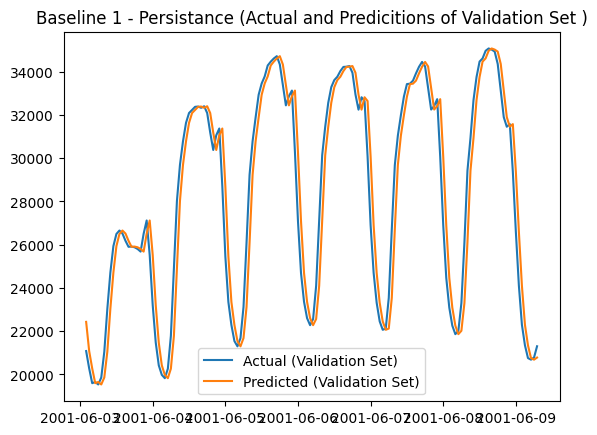

In [ ]:
#print(len(y_acc_val))
#print(len(y_val_pred))

plt.plot(y_acc_val[-150:], label = "Actual (Validation Set)")
plt.plot(y_val_pred[-150:], label = "Predicted (Validation Set)")
plt.legend()
plt.title("Baseline 1 - Persistance (Actual and Predicitions of Validation Set )")
plt.show()

**Baseline 2 - Same hour yesterday**

In [ ]:
#To predict demand at time t (i.e. now) I use the demand that did occur at t-24?

lag_time = 24 # same hour yesterday

y_val_acc_b2 = val_data["PJM_Load_MW"]
val_history = pd.concat([train_data["PJM_Load_MW"].iloc[-lag_time:],y_val_acc_b2])

y_val_pred_24 = val_history.shift(lag_time).loc[y_val_acc_b2.index]

mae_val_b2 = mean_absolute_error(y_val_acc_b2,y_val_pred_24)
rmse_val_b2 = sqrt(mean_squared_error(y_val_acc_b2,y_val_pred_24))

print("========== Validation Set Prediction (Baseline 2: 24hr Lag) ==========")
print(f"MAE: {mae_val_b2:.5f}")
print(f"RMSE: {rmse_val_b2:.5f}")




========== Validation Set Prediction (Baseline 2: 24hr Lag) ==========
MAE: 1821.64154
RMSE: 2535.06586


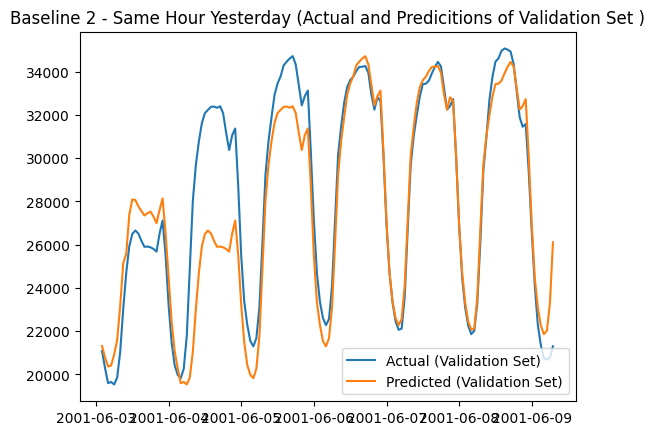

In [ ]:
#print(len(y_val_acc_b2))
#print(len(y_val_pred_24))

plt.plot(y_val_acc_b2[-150:], label = "Actual (Validation Set)")
plt.plot(y_val_pred_24[-150:], label = "Predicted (Validation Set)")
plt.legend()
plt.title("Baseline 2 - Same Hour Yesterday (Actual and Predicitions of Validation Set )")
plt.show()

**Baseline 3 - Same Hour Last Week**

In [ ]:
#To predict demand at time t (i.e. now) I use the demand that did occur at t-168?

lag_time_week = 168 # same hour last week

y_val_acc_b3 = val_data["PJM_Load_MW"]
val_history_week = pd.concat([train_data["PJM_Load_MW"].iloc[-lag_time_week:],y_val_acc_b3])

y_val_pred_168 = val_history_week.shift(lag_time_week).loc[y_val_acc_b3.index]

mask_val = y_val_pred_168.notna()

mae_val_b3 = mean_absolute_error(y_val_acc_b3[mask_val],y_val_pred_168[mask_val])
rmse_val_b3 = sqrt(mean_squared_error(y_val_acc_b3[mask_val],y_val_pred_168[mask_val]))

print("========== Validation Set Prediction (Baseline 3: 168 hr Lag) ==========")
print(f"MAE: {mae_val_b3:.5f}")
print(f"RMSE: {rmse_val_b3:.5f}")


========== Validation Set Prediction (Baseline 3: 168 hr Lag) ==========
MAE: 1831.92361
RMSE: 2376.71664


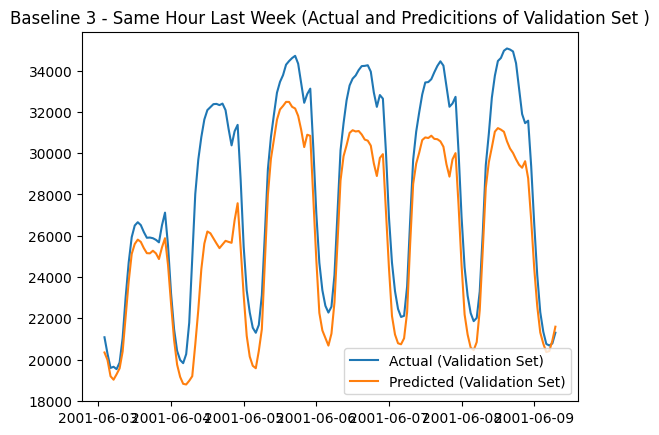

In [ ]:
#print(len(y_val_acc_b3))
#print(len(y_val_pred_168))

plt.plot(y_val_acc_b3[-150:], label = "Actual (Validation Set)")
plt.plot(y_val_pred_168[-150:], label = "Predicted (Validation Set)")
plt.legend()
plt.title("Baseline 3 - Same Hour Last Week (Actual and Predicitions of Validation Set )")
plt.show()

**Baseline 4 - Global Mean**

Text(0.5, 1.0, 'Global Mean Baseline')

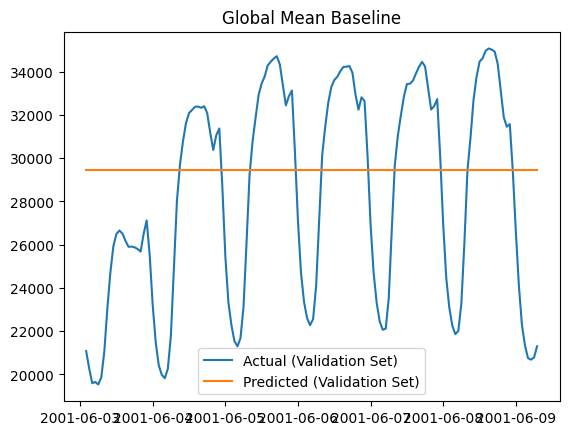

In [ ]:
y_val_acc_b4 = val_data["PJM_Load_MW"]
train_mean = train_data["PJM_Load_MW"].mean()

y_pred_val = pd.Series(train_mean, index = val_data.index)

plt.plot(y_val_acc_b4[-150:], label = "Actual (Validation Set)")
plt.plot(y_pred_val[-150:], label = "Predicted (Validation Set)")
plt.legend()
plt.title("Global Mean Baseline")

In [ ]:
# Global Baseline Error Calcs
mae_val_b4 = mean_absolute_error(y_val_acc_b4,y_pred_val)
rmse_val_b4 = sqrt(mean_squared_error(y_val_acc_b4,y_pred_val))

print(f"Validation Set MAE- {mae_val_b4}")
print(f"Validation Set RMSE - {rmse_val_b4}")






Validation Set MAE- 3812.595211226317
Validation Set RMSE - 4626.528537670148


**Baseline 5 - Simple Moving Average**

In [ ]:
def SMA(data, window):
  return data.rolling(window = window).mean().shift(1)


Text(0.5, 1.0, 'Simple Moving Average(s) Baseline')

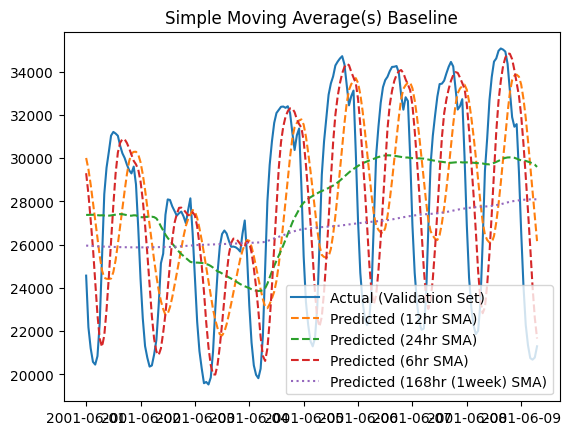

In [ ]:
y_acc_val = val_data["PJM_Load_MW"]

val_history_12 = pd.concat([train_data["PJM_Load_MW"].iloc[-12:],y_acc_val])
val_history_24 = pd.concat([train_data["PJM_Load_MW"].iloc[-24:],y_acc_val])
val_history_6 = pd.concat([train_data["PJM_Load_MW"].iloc[-6:],y_acc_val])
val_history_168 = pd.concat([train_data["PJM_Load_MW"].iloc[-168:],y_acc_val])

y_pred_12 = SMA(val_history_12, 12).loc[y_acc_val.index]
y_pred_24 = SMA(val_history_24, 24).loc[y_acc_val.index]
y_pred_6 = SMA(val_history_6, 6).loc[y_acc_val.index]
y_pred_168 = SMA(val_history_168, 168).loc[y_acc_val.index]

plt.plot(y_acc_val[-200:], label = "Actual (Validation Set)")

plt.plot(y_pred_12[-200:], linestyle = "--",label = "Predicted (12hr SMA)")
plt.plot(y_pred_24[-200:], linestyle = "--",label = "Predicted (24hr SMA)")
plt.plot(y_pred_6[-200:], linestyle = "--",label = "Predicted (6hr SMA)")
plt.plot(y_pred_168[-200:],linestyle = "dotted", label = "Predicted (168hr (1week) SMA)")

plt.legend()
plt.title("Simple Moving Average(s) Baseline")


In [ ]:
# error calcs for different SMAs
mask_12 = y_pred_12.notna()
mask_6 = y_pred_6.notna()
mask_24 = y_pred_24.notna()
mask_168 = y_pred_168.notna()

mae_val_12 = mean_absolute_error(y_acc_val[mask_12],y_pred_12[mask_12])
mae_val_6 = mean_absolute_error(y_acc_val[mask_6],y_pred_6[mask_6])
mae_val_24 = mean_absolute_error(y_acc_val[mask_24],y_pred_24[mask_24])
mae_val_168 = mean_absolute_error(y_acc_val[mask_168],y_pred_168[mask_168])

rmse_val_12 = sqrt(mean_squared_error(y_acc_val[mask_12],y_pred_12[mask_12]))
rmse_val_6 = sqrt(mean_squared_error(y_acc_val[mask_6],y_pred_6[mask_6]))
rmse_val_24 = sqrt(mean_squared_error(y_acc_val[mask_24],y_pred_24[mask_24]))
rmse_val_168 = sqrt(mean_squared_error(y_acc_val[mask_168],y_pred_168[mask_168]))

print(f"MAE - 12hr SMA {mae_val_12}")
print(f"MAE - 6hr SMA {mae_val_6}")
print(f"MAE - 24hr SMA {mae_val_24}")
print(f"MAE - 168hr SMA {mae_val_168}")

print(f"RMSE - 12hr SMA {rmse_val_12}")
print(f"RMSE - 6hr SMA {rmse_val_6}")
print(f"RMSE - 24hr SMA {rmse_val_24}")
print(f"RMSE - 168hr SMA {rmse_val_168}")


MAE - 12hr SMA 3391.5079533941234
MAE - 6hr SMA 2788.1608240459304
MAE - 24hr SMA 3027.421766295171
MAE - 168hr SMA 3388.257269503546
RMSE - 12hr SMA 4036.4061807483326
RMSE - 6hr SMA 3459.807240299481
RMSE - 24hr SMA 3639.389343325637
RMSE - 168hr SMA 3999.6869747837322


**Baseline 6 - Simple Exponential Smoothing**

In [ ]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
# alpha should be between 0 and 1
# forecast steps should be +ve
def SES(data, alpha, forecast_steps, plot):
  alpha = alpha
  model = SimpleExpSmoothing(data, initialization_method = "heuristic")
  fit = model.fit(smoothing_level = alpha, optimized = True)

  predictions = fit.forecast(forecast_steps)

  if plot:
    plt.plot(data.iloc[-150:], label = "Train (Final 150)")
    plt.plot(predictions.iloc[:150], label = "Validations (First 150))", linestyle = "--")
    plt.legend()
    plt.title("Simple Exponential Smoothing")
    plt.show()

  return predictions


y_train = train_data["PJM_Load_MW"]
y_val = val_data["PJM_Load_MW"]

alphas = [0.1,0.25,0.5,0.75, 1.0]

results = []
mae_list = []
rmse_list = []

for a in alphas:
  y_pred = SES(data = y_train, alpha = a, forecast_steps = len(y_val), plot = False)

  mae = mean_absolute_error(y_val,y_pred)
  rmse = sqrt(mean_squared_error(y_val,y_pred))

  mae_list.append(mae)
  rmse_list.append(rmse)

  results.append((a,mae,rmse))



for a, mae, rmse in results:
  print(f"Alpha = {a} resulted in an MAE of {mae} and RMSE of {rmse}")



average_mae_SES = np.mean(mae_list)
average_rmse_SES = np.mean(rmse_list)

print(f"Average MAE for Baseline 6 - SES: {average_mae_SES}")
print(f"Average RMSE for Baseline 6 - SES: {average_rmse_SES}")

/usr/local/lib/python3.12/dist-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


Alpha = 0.1 resulted in an MAE of 3718.756952427577 and RMSE of 4603.182063062275
Alpha = 0.25 resulted in an MAE of 3806.855369691704 and RMSE of 4774.565720513372
Alpha = 0.5 resulted in an MAE of 3830.5845175623417 and RMSE of 4810.447426427962
Alpha = 0.75 resulted in an MAE of 3816.109083628564 and RMSE of 4788.635034386257
Alpha = 1.0 resulted in an MAE of 3816.2606889564336 and RMSE of 4788.863213695217
Average MAE for Baseline 6 - SES: 3797.7133224533236
Average RMSE for Baseline 6 - SES: 4753.138691617017


/usr/local/lib/python3.12/dist-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


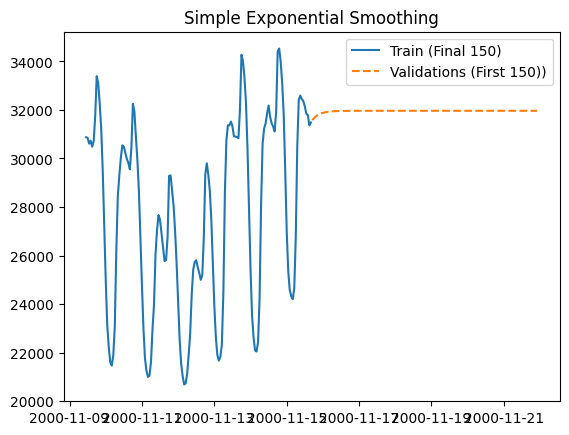

MAE for Baseline 6 - Holt: 3925.5385650254507
RMSE for Baseline 6 - Holt: 4949.817035687874


In [ ]:
from statsmodels.tsa.holtwinters import Holt

def SES_Holt(data, forecast_steps, plot = True, trend = "add", damped_trend = True ):

  model = Holt(data, initialization_method = "heuristic", exponential = (trend == "mul"), damped_trend = damped_trend)
  fit = model.fit( optimized = True)


  predictions = fit.forecast(forecast_steps)

  if plot:
    plt.plot(data.iloc[-150:], label = "Train (Final 150)")
    plt.plot(predictions.iloc[:150], label = "Validations (First 150))", linestyle = "--")
    plt.legend()
    plt.title("Simple Exponential Smoothing")
    plt.show()

  return predictions


y_train = train_data["PJM_Load_MW"]
y_val = val_data["PJM_Load_MW"]

y_preds_holt = SES_Holt(data = y_train,forecast_steps =  len(y_val), plot = True)

mae_holt = mean_absolute_error(y_val,y_preds_holt)
rmse_holt = sqrt(mean_squared_error(y_val,y_preds_holt))

print(f"MAE for Baseline 6 - Holt: {mae_holt}")
print(f"RMSE for Baseline 6 - Holt: {rmse_holt}")


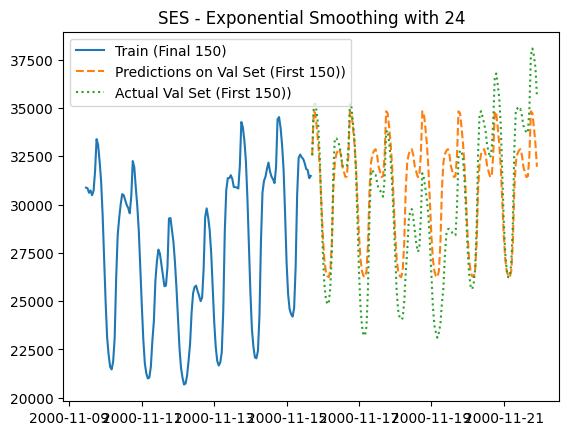

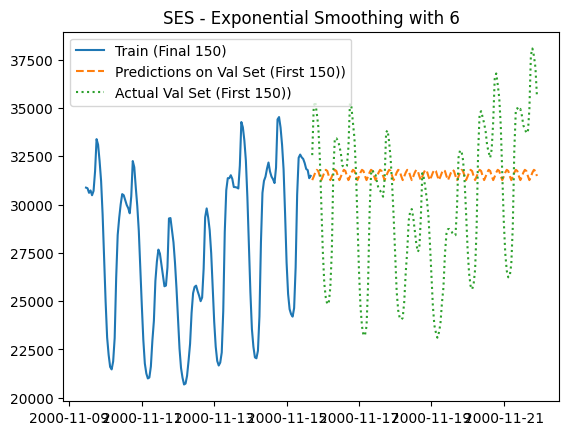

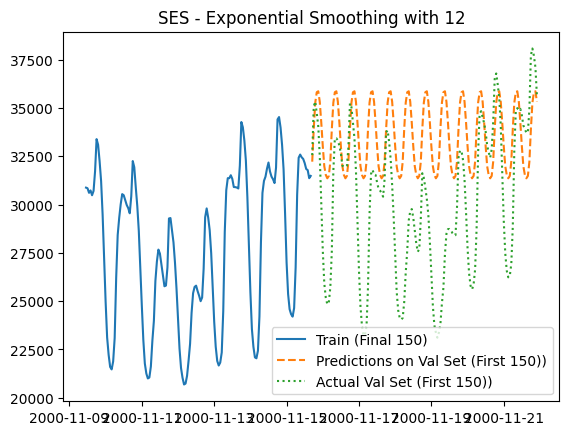

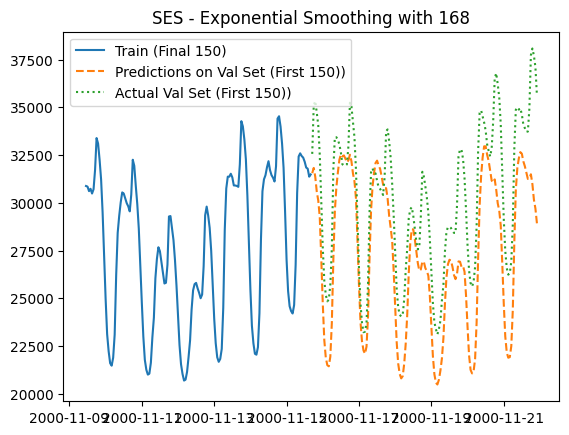

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

def SES_ExpSmoo(data,forecast_steps, seasonal_periods, plot = True, trend = None, seasonal = "add"):

  model = ExponentialSmoothing(data, trend = trend, seasonal = seasonal, seasonal_periods = seasonal_periods, initialization_method = "heuristic")
  fit = model.fit( optimized = True)


  predictions = fit.forecast(forecast_steps)

  if plot:
    plt.plot(data.iloc[-150:], label = "Train (Final 150)")
    plt.plot(predictions.iloc[:150], label = "Predictions on Val Set (First 150))", linestyle = "--")
    plt.plot(y_val.iloc[:150], label = "Actual Val Set (First 150))", linestyle = ":")
    plt.legend()
    plt.title(f"SES - Exponential Smoothing with {seasonal_periods}")
    plt.show()

  return predictions


y_train = train_data["PJM_Load_MW"]
y_val = val_data["PJM_Load_MW"]


seasonal_periods = [6,12,24,168]


y_preds_24 = SES_ExpSmoo(data = y_train,forecast_steps =  len(y_val), seasonal_periods = 24, plot = True, trend = None, seasonal = "add")
y_preds_6 = SES_ExpSmoo(data = y_train,forecast_steps =  len(y_val), seasonal_periods = 6, plot = True, trend = None, seasonal = "add")
y_preds_12 = SES_ExpSmoo(data = y_train,forecast_steps =  len(y_val), seasonal_periods = 12, plot = True, trend = None, seasonal = "add")
y_preds_168 = SES_ExpSmoo(data = y_train,forecast_steps =  len(y_val), seasonal_periods = 168, plot = True, trend = None, seasonal = "add")




In [ ]:
periods = [24,6,12,168]

ses_exp_smoo_mae_24 = mean_absolute_error(y_val,y_preds_24)
ses_exp_smoo_mae_6 = mean_absolute_error(y_val,y_preds_6)
ses_exp_smoo_mae_12 = mean_absolute_error(y_val,y_preds_12)
ses_exp_smoo_mae_168 = mean_absolute_error(y_val,y_preds_168)

mae_list = [ses_exp_smoo_mae_24,ses_exp_smoo_mae_6,ses_exp_smoo_mae_12,ses_exp_smoo_mae_12]

ses_expo_rmse_24 = sqrt(mean_squared_error(y_val,y_preds_24))
ses_expo_rmse_6 = sqrt(mean_squared_error(y_val,y_preds_6))
ses_expo_rmse_12 = sqrt(mean_squared_error(y_val,y_preds_12))
ses_expo_rmse_168 = sqrt(mean_squared_error(y_val,y_preds_168))

rmse_list = [ses_expo_rmse_24,ses_expo_rmse_6,ses_expo_rmse_12,ses_expo_rmse_168]

for p,m,r in zip(periods,mae_list,rmse_list):
  print(f"When the seasonal period is: {p}, the MAE is {m} and the RMSE is {r}")


When the seasonal period is: 24, the MAE is 2771.794742650258 and the RMSE is 3512.495109987526
When the seasonal period is: 6, the MAE is 3828.4794219264504 and the RMSE is 4809.78305380342
When the seasonal period is: 12, the MAE is 4364.024107503468 and the RMSE is 5454.620832680221
When the seasonal period is: 168, the MAE is 4364.024107503468 and the RMSE is 4103.256729951214


**Bar Plots - Error (Validation Only)**

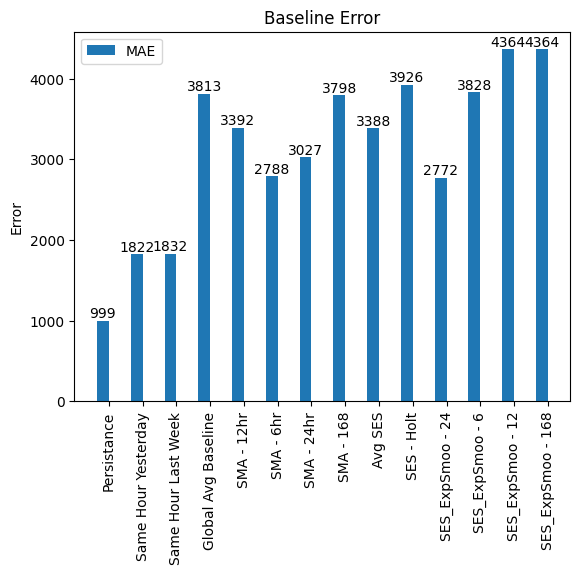

In [ ]:
lables = ["Persistance",
          "Same Hour Yesterday",
          "Same Hour Last Week",
          "Global Avg Baseline",
          "SMA - 12hr",
          "SMA - 6hr",
          "SMA - 24hr",
          "SMA - 168",
          "Avg SES",
          "SES - Holt",
          "SES_ExpSmoo - 24",
          "SES_ExpSmoo - 6",
          "SES_ExpSmoo - 12",
          "SES_ExpSmoo - 168"]

mae = [mae_val,mae_val_b2,mae_val_b3,mae_val_b4,mae_val_12,mae_val_6,mae_val_24, average_mae_SES,mae_val_168, mae_holt,ses_exp_smoo_mae_24,ses_exp_smoo_mae_6,ses_exp_smoo_mae_12,ses_exp_smoo_mae_12]

x = np.arange(len(lables))
width = 0.35

mae_plot = plt.bar(x-width/2, mae, width,label = "MAE")
#plt.bar(x+width/2, rmse, width, label = "RMSE") ends up being to small (relative to the mae bars - plotted seperatelt)


def annotate(bars):
  for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2,
    height,
    f"{height:.0f}",
    ha = "center",
    va = "bottom",
    fontsize = 10)


annotate(mae_plot)


plt.xticks(x, lables, rotation = 90)
plt.ylabel("Error")
plt.legend()
plt.title("Baseline Error")
plt.show()

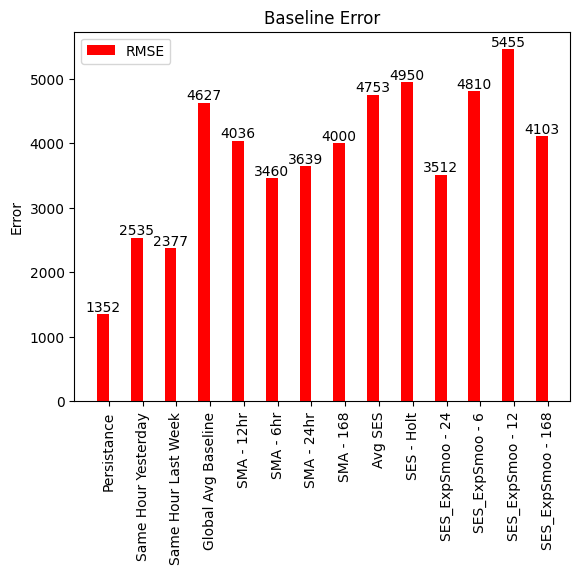

In [ ]:
rmse = [rmse_val,rmse_val_b2,rmse_val_b3, rmse_val_b4, rmse_val_12, rmse_val_6, rmse_val_24, rmse_val_168,average_rmse_SES,rmse_holt,ses_expo_rmse_24,ses_expo_rmse_6,ses_expo_rmse_12,ses_expo_rmse_168]

x = np.arange(len(lables))

rmse_plot = plt.bar(x-width/2, rmse, width, label = "RMSE", color = "red")


annotate(rmse_plot)

plt.xticks(x, lables, rotation = 90)
plt.ylabel("Error")
plt.legend()
plt.title("Baseline Error")
plt.show()

In [ ]:
for l,m,r in zip(lables, mae,rmse):
  print(f"For {l} the MAE is {m:.3f} and the RMSE is {r:.3f}")

For Persistance the MAE is 999.219 and the RMSE is 1351.670
For Same Hour Yesterday the MAE is 1821.642 and the RMSE is 2535.066
For Same Hour Last Week the MAE is 1831.924 and the RMSE is 2376.717
For Global Avg Baseline the MAE is 3812.595 and the RMSE is 4626.529
For SMA - 12hr the MAE is 3391.508 and the RMSE is 4036.406
For SMA - 6hr the MAE is 2788.161 and the RMSE is 3459.807
For SMA - 24hr the MAE is 3027.422 and the RMSE is 3639.389
For SMA - 168 the MAE is 3797.713 and the RMSE is 3999.687
For Avg SES the MAE is 3388.257 and the RMSE is 4753.139
For SES - Holt the MAE is 3925.539 and the RMSE is 4949.817
For SES_ExpSmoo - 24 the MAE is 2771.795 and the RMSE is 3512.495
For SES_ExpSmoo - 6 the MAE is 3828.479 and the RMSE is 4809.783
For SES_ExpSmoo - 12 the MAE is 4364.024 and the RMSE is 5454.621
For SES_ExpSmoo - 168 the MAE is 4364.024 and the RMSE is 4103.257


In [ ]:
val_results = {}

for i in range(len(lables)):
  val_results[lables[i]] = [mae[i], rmse[i]]


In [ ]:
val_results = pd.DataFrame(val_results, index = ["MAE", "RMSE"])

In [ ]:
val_results.T.sort_values("MAE")

,MAE,RMSE
Persistance,999.219048,1351.669939
Same Hour Yesterday,1821.641540,2535.065862
Same Hour Last Week,1831.923607,2376.716641
SES_ExpSmoo - 24,2771.794743,3512.495110
SMA - 6hr,2788.160824,3459.807240
SMA - 24hr,3027.421766,3639.389343
Avg SES,3388.257270,4753.138692
SMA - 12hr,3391.507953,4036.406181
SMA - 168,3797.713322,3999.686975
Global Avg Baseline,3812.595211,4626.528538


# Baselines Findings

---
The bar plot above shows the MAE and RMSE values for each of the baselines. From an intuitive standpoint, it was obvious that that the Persistance/Random Walk baseline would have the lowest error. This is obvious when thought about.

Suppose, temperature readings are carried out in the middle of the day under all standard conditions i.e. Room Temperature, Standard Pressure etc - it is very unlikely for the temperature to change significanlty within an hour, and assuming that the temperature would stay the same at t+1 hour would not be an erroneous choice.
Applying that methodological mindset to PJM_Load Dataset, it becomes obvious why Persistance has the lowest MAE and RMSE (~ 999 and ~1352 respectively).

The "Same Hour Yesterday" and "Same Hour Last Week" had similar results with MAEs of 1822 and 1805 respectively and similarly, RMSEs of 2535 and 2560. These suggest that in terms of prediciting hourly data, bought falter when compared to the Persistance model however, both methods seem to perform at similar levels and relative to the Global avg baseline and all the SMAs, these two methods perform significantly better. It shows that the trend was captured (albeit not that accurately) between yesterday and previous 7 days.

On the extreme end of baseline results, a simple exponential smoothing (SES) was implemented. However, its results did not indicate a performance that was better than the persistance model. Multiple alphas (smoothing parameter) were tried ranging from 0.1 to 1.0 and and average MAE and RMSE were computed. The average MAE was 3388 and an average RMSE was 4753. Although the MAE was not the worst, it certainly does not compete with the Persistance model. A variation of the SSE was also implemented titled SSE-Holt. Its MAE and RMSE were worse then the standard SSE, scoring a MAE value of 3925 and a RMSE value of 4949. These results indicate that the Holt method did not result in an improvement but rather worsened performence in terms of predicting short term movement. Both SES and SES - Holt had the optimised parameter set to True, meaning the predictions were based on optimised parameters.

A final version, called Holt-Winters (titled as SES ExpSmoo - n) was also implemented. n = time periods (the same windows as the SMA were implemented). The results varied based on the period implemented. The best performing SES ExpSmoo was the 24 period with a MAE of 2772 and RMSE of 3512. It performed better than SMA-24 as well global mean, SES and SES -Holt. However it still performs worse than Persistance (which had a MAE of about 999). This is due to the fact that this model works better on seasonal structured data and not short term hourly data.

A final conclusion to the baseline tests. For 1-hour ahead electricity demand forecasting persistance is a very strong baseline that is so far proving to be difficult to be beat without additional information (i.e. weather)




---

**Whats Next?**

This dataset was downloaded from Kaggle (link above) as such, there is not much extra information. Without extra variables like weather and temperature, persistance will be very difficult to be beat. However, a greater reason for the difficulty in beating persistance is the nature of the data and how persistance works. As mentioned above, it is very unlikely for eletricity prices to change hour by hour by significant amounts.  The short-term / short-horizon has a very strong dominance and this is shown on the strong persistance results and the weaker values of other baseline tests.

The next part of this project will feature the traditional day-ahead predicition. It will follow similar baselines construction in the beginning and will then continue from there (the assumption is that for day-ahead, persistance will be much easier to beat and may not even be the main baseline)


* This notebook featured an end-to-end forecasting pipeline for electricity demand using the historical PJM load data (Kaggle)showing the focus on rigorous baseline evaluations.

* Performed multiple time-series integrity checks including timestamp continuity, Daylight Saving Time effects and missing data as well. Corrected inconsistencies via interpolation.

* Implemented and compared multiple naive and statistical baseline such as:
-   Persistance
-   Same hour yesterday/ last week
-   Global Mean
-   Simple Moving Averages (6hr, 12hr, 24hr, 168hr)
-   Simple Exponential Smoothing, Holt and Exponential Smoothing.

* Models were evaluated using MAE and RMSE on validation splits - Persistance demonstrated to be the most dominant benchmark for 1hr ahead forecasting